In [1]:
from feature_engineering.dao.sussex_huawei_dao import SussexHuaweiDAO
from feature_engineering.preprocessing.sussex_huawei_preprocessor import SussexHuaweiPreprocessor
import matplotlib as plt
import seaborn as sns

In [2]:
dao = SussexHuaweiDAO()
preprocessor = SussexHuaweiPreprocessor()

In [3]:
# 1. Load Data
label_column_names = ['coarse_label', 'fine_label', 'road_label']
labels = dao.read_data(
            '/home/lorenz/PycharmProjects/rctc_pipeline/data_sets/sussex_huawei/User1/220617/Label.txt', #TODO: Pack in config/.env
            column_names=label_column_names, use_columns=[1, 2, 3])
data_column_names = ['time', 'acceleration_x', 'acceleration_y', 'acceleration_z', #TODO: Pack in config/.env
                             'gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                             'magnetometer_x', 'magnetometer_y', 'magnetometer_z',
                             'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z',
                             'gravity_x', 'gravity_y', 'gravity_z',
                             'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                             ]
data = dao.read_data(
        '/home/lorenz/PycharmProjects/rctc_pipeline/data_sets/sussex_huawei/User1/220617/Bag_Motion.txt', #TODO: Pack in config/.env
        column_names=data_column_names, use_columns=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])


In [4]:
# 2. Preprocessing

# 2.1 Convert unix time (ms) to date time
data = preprocessor.convert_unix_to_datetime(data, column = 'time', unit = 'ms')

# 2.2 Label data and remove NaNs
data = preprocessor.label_data(data, labels)
data = preprocessor.remove_nans(data, replacement_mode='del_row')

# 2.3 Normalization
acelerometer_columns = ['acceleration_x', 'acceleration_y', 'acceleration_z']
gravity_columns = ['gravity_x', 'gravity_y', 'gravity_z']
data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='known_gravity', 
            target_columns = acelerometer_columns,
            support_columns = gravity_columns)

#data = preprocessor.znormalize_quantitative_data(data, data_column_names[1:])
#data = preprocessor.min_max_normalize_quantitative_data(data, data_column_names)

# 2.4 Segment data
# Coarse Label: Null=0, Still=1, Walking=2, Run=3, Bike=4, Car=5, Bus=6, Train=7, Subway=8
# Road Label: City=1, Motorway=2, Countryside=3, Dirt road=4, Null=0
selected_coarse_labels = [5]
selected_road_labels = [1, 3]
car_segments = preprocessor.segment_data(data, mode='labels', 
                                 label_column='coarse_label', 
                                 support=selected_coarse_labels)

data_segments = []
for car_segment in car_segments:
        road_segments = preprocessor.segment_data(car_segment, mode='labels', 
                                  label_column='road_label',
                                  support=selected_road_labels
                                )
        for road_segment in road_segments:
            data_segments.append(road_segment)
            


In [7]:
#https://stackoverflow.com/questions/19231871/convert-unix-time-to-readable-date-in-pandas-dataframe
#https://stackoverflow.com/questions/55474088/only-valid-with-datetimeindex-timedeltaindex-or-periodindex-but-got-an-instanc
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
#https://stackoverflow.com/questions/42698421/pandas-to-datetime-from-milliseconds-produces-incorrect-datetime
print(len(data_segments[1]))

#print(data_segments[1])
#data_segments[1]['time'] = data_segments[1]['time'].astype('int64')
#print(data_segments[1]['time'].iloc[0])
#print(data_segments[1]['time'].astype('float64').iloc[2])
#print(datetime.datetime.fromtimestamp(data_segments[1]['time'].iloc[2].astype(numpy.int64)))
#datetime.datetime(2017, 2, 27, 23, 0)
#print(pandas.to_datetime(data_segments[1]['time'],unit='ms'))
#print(data_segments[1])
data_segments[1] = data_segments[1].set_index('time')#.resample('s', on='time').mean()
filtered = preprocessor.resample_quantitative_data(data_segments[1], freq='1S')
print(filtered)
#print(len(data_segments[1]))
#print(1498120298210)

#print((data_segments[1]['time'].iloc[0]*-1000000000000).astype(numpy.int64))
#print((data_segments[1]['time'].iloc[1]*-1000000000000).astype(numpy.int64))
#print(1498120298210)
#print(datetime.datetime.fromtimestamp((data_segments[1]['time'].iloc[0]*-1000000000).astype(numpy.int64)))
#asd = pandas.to_datetime((data_segments[1]['time']),unit='ms')
#asd

288035
                     acceleration_x  acceleration_y  acceleration_z  \
time                                                                  
2017-06-22 09:37:04       -0.277742       -0.130129       -0.320774   
2017-06-22 09:37:05       -0.302009       -0.129778       -0.422409   
2017-06-22 09:37:06       -0.063310        0.041208       -0.382692   
2017-06-22 09:37:07        0.139475        0.242120       -0.098664   
2017-06-22 09:37:08        0.078516        0.141627       -0.151605   
2017-06-22 09:37:09        0.090130        0.214816       -0.075330   
2017-06-22 09:37:10        0.155485        0.368206        0.057973   
2017-06-22 09:37:11        0.022233        0.107365       -0.139080   
2017-06-22 09:37:12       -0.060636       -0.086615       -0.259158   
2017-06-22 09:37:13        0.152444        0.414630        0.110486   
2017-06-22 09:37:14        0.056827        0.230383       -0.074686   
2017-06-22 09:37:15       -0.089963       -0.121980       -0.305714   

In [ ]:
#filtered = data_segments[1].resample('300U').mean()
#print(filtered)

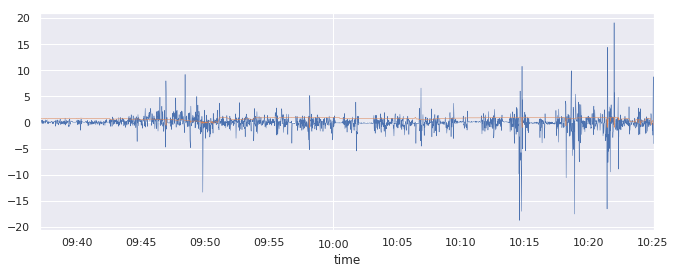

In [13]:
# Visual anlaysis:
sns.set(rc={'figure.figsize':(11, 4)})
import numpy
(filtered['acceleration_x']*(filtered['orientation_x']/filtered['orientation_w'])).plot(linewidth=0.5);
(filtered['orientation_x']).plot(linewidth=0.5);
#filtered[1]['coarse_label'].plot(linewidth=0.5);
#filtered[1]['road_label'].plot(linewidth=0.5);
#filtered['acceleration_z'].plot(linewidth=0.5);
#print(data.keys())


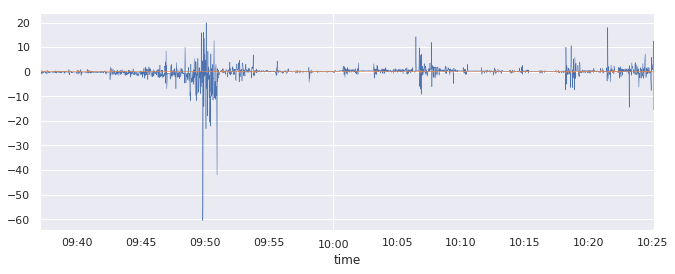

In [10]:
(filtered['acceleration_y']*(filtered['orientation_y']/filtered['orientation_w'])).plot(linewidth=0.5);
(filtered['acceleration_y']).plot(linewidth=0.5);